Exploratory Data Analysis (EDA) of Temperature Change Dataset

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot

# Load the dataset
file_path = 'Updated_Temperature_Change_India_China_UK.xlsx'
df = pd.read_excel(file_path, engine='openpyxl')

# Display the first few rows of the dataframe
df.head()

,Area Code,Area,Months Code,Months,Element Code,Baseline Temperature (1961–1990 Avg),Element,Unit,Y1961,Y1962,...,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,Y2018,Y2019
0,351,China,7001,January,7271,0.369667,Temperature change,°C,-0.012,-0.468,...,1.857,-1.954,-0.720,0.548,2.340,2.610,0.543,2.549,0.654,2.008
1,351,China,7001,January,6078,NaN,Standard Deviation,°C,0.942,0.942,...,0.942,0.942,0.942,0.942,0.942,0.942,0.942,0.942,0.942,0.942
2,351,China,7002,February,7271,0.143533,Temperature change,°C,0.353,1.046,...,1.430,2.311,0.133,1.687,0.575,2.757,1.511,3.123,1.055,1.805
3,351,China,7002,February,6078,NaN,Standard Deviation,°C,1.553,1.553,...,1.553,1.553,1.553,1.553,1.553,1.553,1.553,1.553,1.553,1.553
4,351,China,7003,March,7271,0.089167,Temperature change,°C,0.275,-0.505,...,0.359,-0.634,0.429,2.581,2.098,2.448,2.677,0.232,3.610,2.348


In [24]:
# Filter to keep only 'Temperature change' rows
df_temp = df[df['Element'] == 'Temperature change'].copy()

# Melt the dataframe to long format for time series analysis
df_melted = df_temp.melt(
    id_vars=['Area', 'Months'],
    value_vars=[col for col in df.columns if col.startswith('Y')],
    var_name='Year',
    value_name='Temperature_Change'
)

# Convert 'Year' to numeric
df_melted['Year'] = df_melted['Year'].str.extract(r'(\d+)').astype(int)
# Combine into datetime format using Year and Month
month_mapping = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12
}
df_melted['Month'] = df_melted['Months'].map(month_mapping)
df_melted['Date'] = pd.to_datetime(df_melted[['Year', 'Month']].assign(DAY=1))

# Reorder and sort
df_ts = df_melted[['Date', 'Area', 'Temperature_Change']].sort_values(['Area', 'Date'])
print(df_ts.head())


        Date   Area  Temperature_Change
0 1961-01-01  China              -0.012
1 1961-02-01  China               0.353
2 1961-03-01  China               0.275
3 1961-04-01  China               0.884
4 1961-05-01  China              -0.135


1. Monthly Temperature Change Over Time by Country

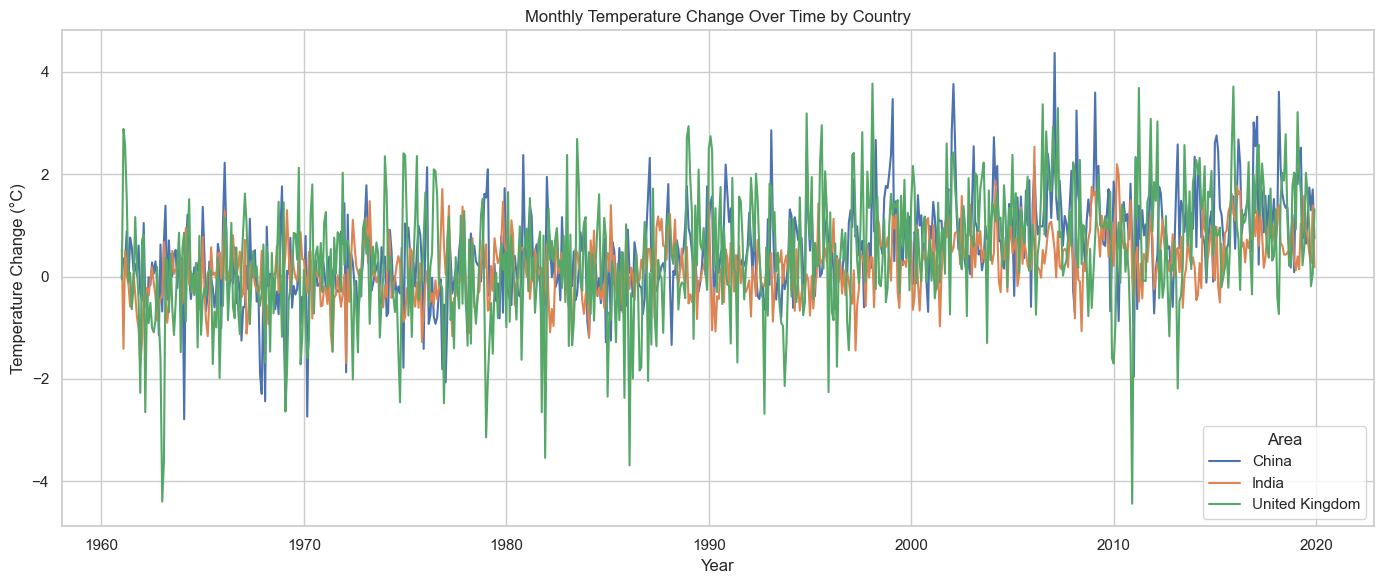

In [8]:
# Set general plot style
sns.set(style="whitegrid")
import matplotlib.dates as mdates

# 1. Line plot of monthly temperature change for each country over time
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_ts , x='Date', y='Temperature_Change', hue='Area')
plt.title('Monthly Temperature Change Over Time by Country')
plt.xlabel('Year')
plt.ylabel('Temperature Change (°C)')
plt.tight_layout()
plt.show()

The graph shows monthly temperature variations from 1961 to 2019 for India, China, and the UK, showing a distinct increasing trend suggestinf  global warming. All three countries shows consistent seasonal variations; nevertheless, a marked acceleration in temperature rise is seen post-2000. India has greater fluctuation, perhaps attributable to monsoonal effects, whereas China and the UK present more consistent warming trends. Short intervals of cooling in previous decades may indicate natural climate cycles or exogenous influences. The graphic underscores the escalating effects of climate change across several locations, highlighting the necessity for comprehensive investigation and proactive environmental measures.

2.Average Yearly Temperature Change by Country






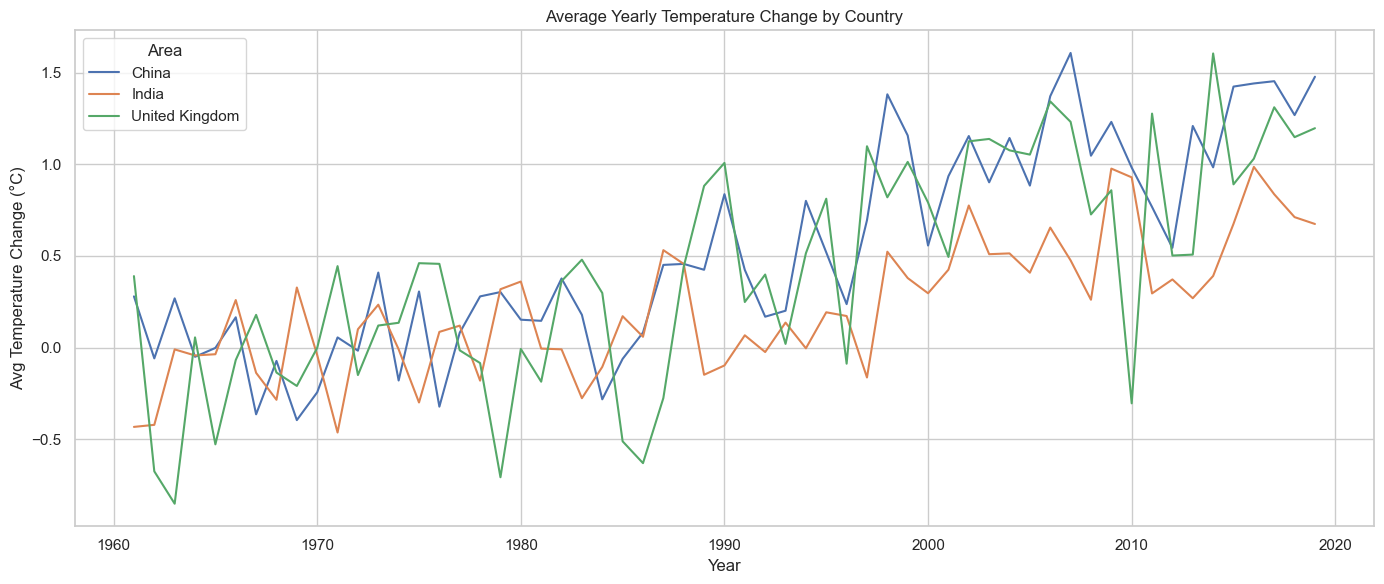

In [11]:
# 2. Yearly average temperature change for each country
df_ts['Year'] = df_ts['Date'].dt.year
df_yearly = df_ts.groupby(['Year', 'Area'])['Temperature_Change'].mean().reset_index()

plt.figure(figsize=(14, 6))
sns.lineplot(data=df_yearly, x='Year', y='Temperature_Change', hue='Area')
plt.title('Average Yearly Temperature Change by Country')
plt.xlabel('Year')
plt.ylabel('Avg Temperature Change (°C)')
plt.tight_layout()
plt.show()

The graph shows the average annual temperature change for China, India, and the UK between 1961 and 2019. Long-term global warming is indicated by the distinct increasing trend seen in all three nations.  In contrast to China and India, which show greater volatility, especially in previous decades, the UK's path is rather stable and smooth.  All regions have a more noticeable warming trend after 2000.  China has a notable increase after 1990, whereas India's variations point to potential monsoonal factors.  The increasing impact of climate change across various geographic and climatic zones is reinforced by this aggregated annual picture, which smoothes seasonal impacts and highlights persistent rises in average temperatures.

3. Monthly Temperature Change Distribution by Country

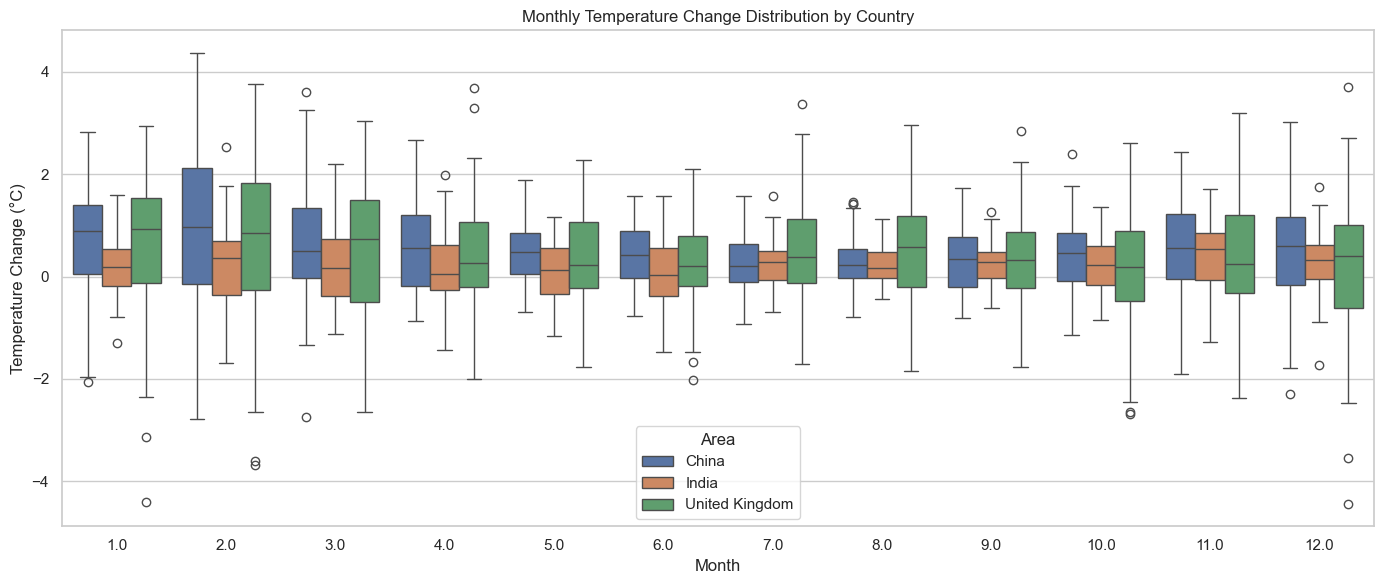

In [12]:
# 3. Boxplot to show monthly seasonality
df_ts['Month'] = df_ts['Date'].dt.month

plt.figure(figsize=(14, 6))
sns.boxplot(data=df_ts, x='Month', y='Temperature_Change', hue='Area')
plt.title('Monthly Temperature Change Distribution by Country')
plt.xlabel('Month')
plt.ylabel('Temperature Change (°C)')
plt.tight_layout()
plt.show()

The monthly distribution of temperature changes for China, India, and the UK from 1961 to 2019 is displayed in the boxplot. With monthly variations in temperature anomalies, it has strong seasonal patterns.  The median temperature fluctuates more throughout the summer months, particularly in India.  Although there is still unpredictability, the monthly distributions in China and the UK are more consistent.  Greater dispersion and volatility in monthly temperatures are indicated by wider boxes.  India's distribution is more dispersed during the monsoon season, indicating the effect of regional climate.  The significance of including month-wise and region-wise data in climate research is supported by this visualisation, which successfully illustrates how temperature change patterns vary by season and nation.

4.Year-Month Heatmap Of Average Temperature Change (All Countries)




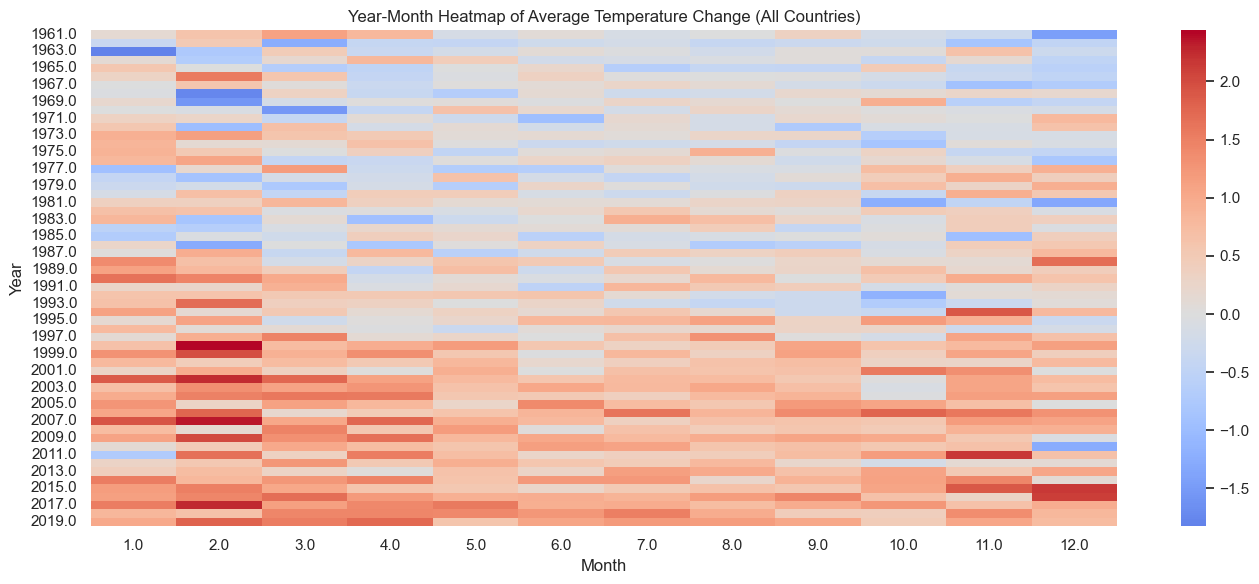

In [13]:
# 4. Heatmap of temperature changes over years and months
pivot = df_ts.pivot_table(index=df_ts['Date'].dt.year,
                          columns=df_ts['Date'].dt.month,
                          values='Temperature_Change',
                          aggfunc='mean')

plt.figure(figsize=(14, 6))
sns.heatmap(pivot, cmap='coolwarm', center=0, annot=False, fmt=".2f")
plt.title('Year-Month Heatmap of Average Temperature Change (All Countries)')
plt.xlabel('Month')
plt.ylabel('Year')
plt.tight_layout()
plt.show()

The heatmap, which combines data from China, India, and the UK, shows the average temperature change throughout months and years from 1961 to 2019.  Cooler hues indicate smaller or negative temperature fluctuations, whereas warmer hues indicate larger temperature shifts.  The map displays distinct cyclical cycles, with greater anomalies often occurring during the summer months.  A clear movement towards warmer shades over time, particularly after 1990, indicates rising global temperatures.  Reds and oranges predominate in the most recent decades, indicating a persistent warming trend.  Both long-term climatic change and short-term (monthly) seasonality are well represented in this graphic for each of the three nations.

5. Seasonal Decomposition of Monthly Temperature Change – UK

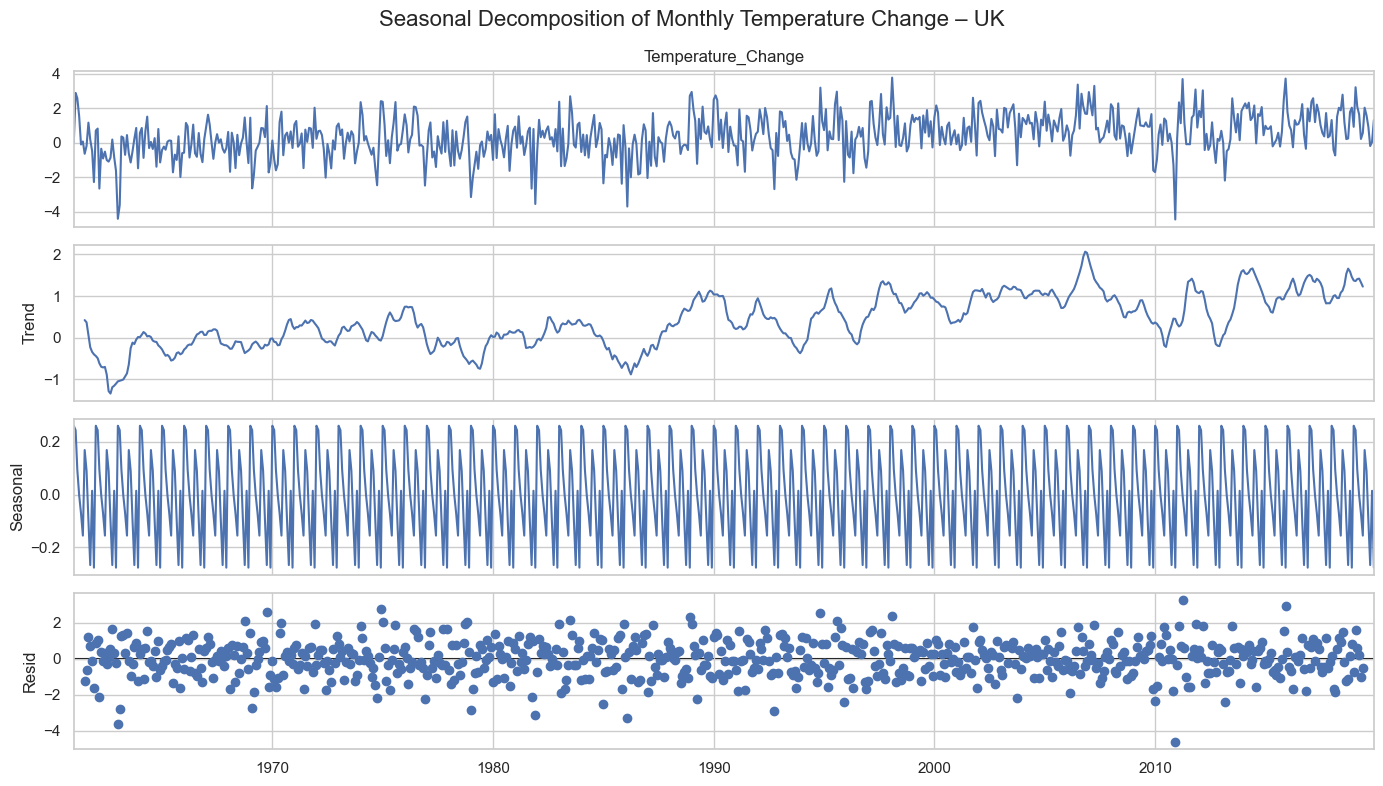

In [28]:
# Filter UK data
df_uk = df_ts[df_ts['Area'] == 'United Kingdom'][['Date', 'Temperature_Change']]

# Set index to date
df_uk.set_index('Date', inplace=True)

# Resample monthly using 'MS' for month start
df_uk_monthly = df_uk.resample('MS').mean(numeric_only=True)

#Seasonal decomposition
result = seasonal_decompose(df_uk_monthly['Temperature_Change'], model='additive', period=12)

# 5. Plot the decomposition
fig = result.plot()
fig.set_size_inches(14, 8)
fig.suptitle('Seasonal Decomposition of Monthly Temperature Change – UK', fontsize=16)
plt.tight_layout()
plt.show()


Three main elements are shown by this seasonal breakdown of the monthly temperature change in the UK: trend, seasonality, and residuals.  Confirming the UK's decades-long warming, the trend component displays a consistent increasing trajectory.  The seasonal pattern is obviously cyclical, with yearly peaks and falls that are predictable and probably caused by cycles in the natural environment.  The residuals emphasise short-term abnormalities by representing random changes that cannot be explained by trend or seasonality. This breakdown makes it easier to comprehend how long-term climate change interacts with typical climatic trends.

6. Autocorrelation of Monthly Temperature Change – India

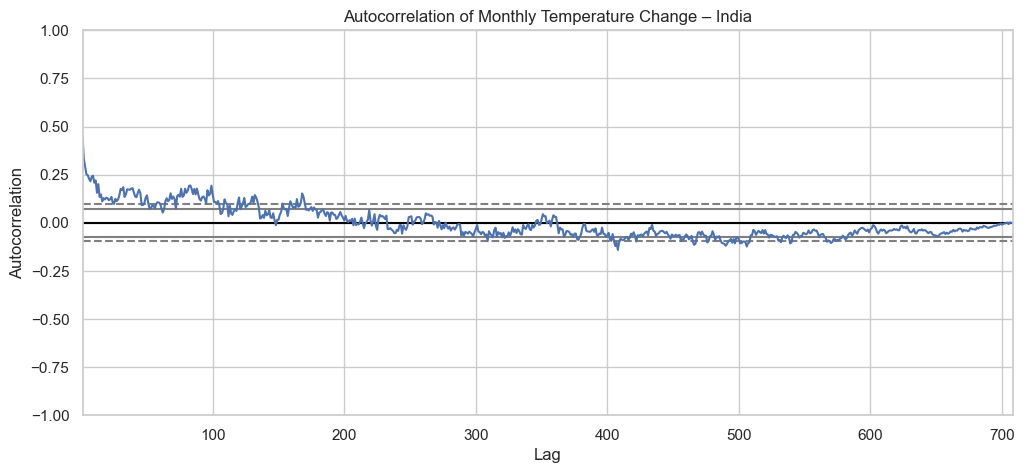

In [30]:
# 6. Autocorrelation plot for India's temperature data

#Filter only India's temperature change column
df_india = df_ts[df_ts['Area'] == 'India'][['Date', 'Temperature_Change']]

# Set datetime index
df_india.set_index('Date', inplace=True)

#Resample to monthly data using month-start ('MS') and take mean
df_india_monthly = df_india.resample('MS').mean(numeric_only=True)

#Autocorrelation plot
plt.figure(figsize=(12, 5))
autocorrelation_plot(df_india_monthly['Temperature_Change'].dropna())
plt.title('Autocorrelation of Monthly Temperature Change – India')
plt.grid(True)
plt.show()


Strong positive correlations are seen at delays 12, 24, and beyond in the autocorrelation plot for India's monthly temperature change, suggesting a distinct annual seasonal cycle. This indicates that a month's temperature is significantly impacted by the same month in prior years. Long-term patterns and durability in the data are suggested by the slower decay of autocorrelation values. 
note:Since data is monthly, a lag of 12 means 12 months ago (i.e., 1 year ago).
     A lag of 24 means 24 months ago (2 years ago), and so on. 

7. Rolling Mean and Standard Deviation – China

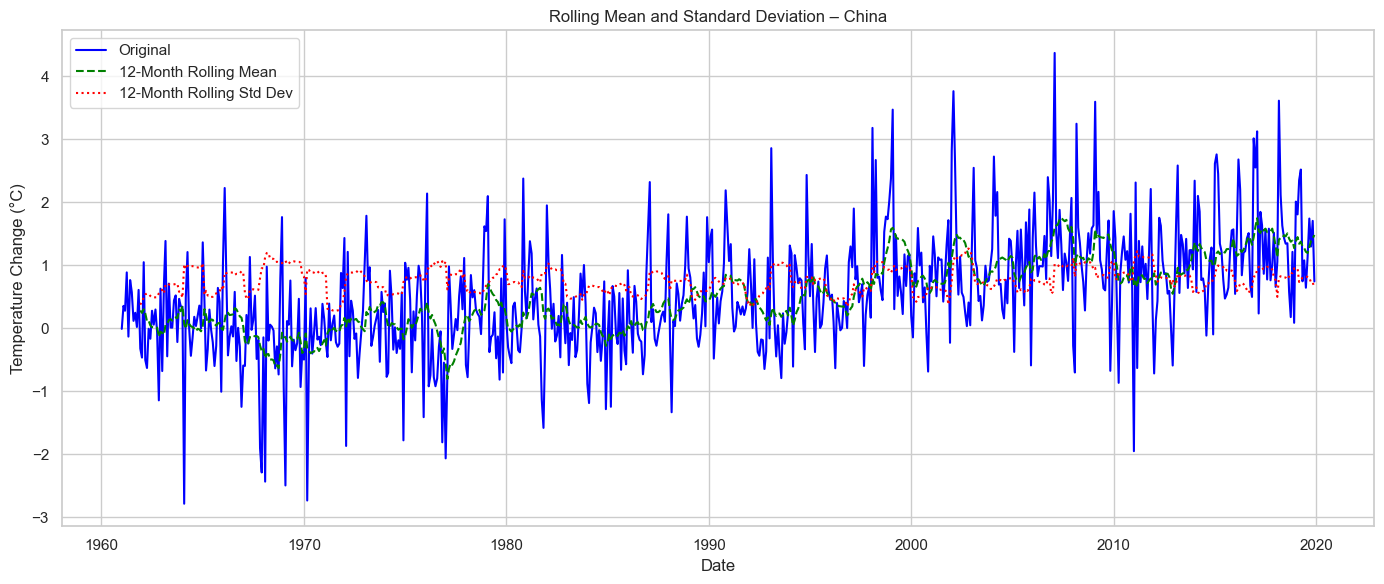

In [32]:
# 7. Rolling mean and standard deviation for China

#Filter China data and only keep numeric column
df_china = df_ts[df_ts['Area'] == 'China'][['Date', 'Temperature_Change']]

#Set date index
df_china.set_index('Date', inplace=True)

#Resample monthly and compute rolling stats
df_china_monthly = df_china.resample('MS').mean(numeric_only=True)

#Calculate 12-month rolling mean and std
rolling_mean = df_china_monthly['Temperature_Change'].rolling(window=12).mean()
rolling_std = df_china_monthly['Temperature_Change'].rolling(window=12).std()

# Plot
plt.figure(figsize=(14, 6))
plt.plot(df_china_monthly['Temperature_Change'], label='Original', color='blue')
plt.plot(rolling_mean, label='12-Month Rolling Mean', linestyle='--', color='green')
plt.plot(rolling_std, label='12-Month Rolling Std Dev', linestyle=':', color='red')
plt.title('Rolling Mean and Standard Deviation – China')
plt.xlabel('Date')
plt.ylabel('Temperature Change (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The standard deviation and 12-month rolling average of China's monthly temperature change from 1961 to 2019 are plotted below.  Long-term warming is confirmed by a rising trend in the rolling mean.  The rolling standard deviation varies throughout decades, reflecting different levels of climatic volatility.  These trends support the idea that the series is non-stationary, meaning that both the variance and the mean fluctuate over time. 